# Problème des k-bandits manchots
- Université Paris Dauphine - PSL
- Master 2 IASD en apprentissage (2022-2023)
- Module : Apprentissage par renforcement
- TP réalisé par :
    - YBEGGAZENE Zakaria
    - AYARI Aziz

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# nombre de machines
k = 10

## Fonctions d'utilité

In [3]:
def generate_means(k):
    # Générer des moyennes pour nos k machines à partir d'une distribution N(0,1)
    return [np.random.normal(0, 1) for _ in range(k)]

In [4]:
def play_machine(a, means):
    # Jouer la machine dont la moyenne est à l'indice "a" et retourner la récompense obtenue
    return np.random.normal(means[a], 1)

## Première approche : méthode ε-glouton

In [5]:
def epsilon_greedy_run(k, means, epsilon=0.01, niter=1000):
    # Effectuer niter itérations avec la méthode ε-glouton
    #avg_count = {i: [0, 0] for i in range(k)}
    Qt = np.zeros((k), dtype=float)
    Nt = np.zeros((k), dtype=float)
    best_known_action = np.random.randint(0, k)
    optimal_action = max(enumerate(means), key=lambda x: x[1])[0]
    rewards = np.zeros((niter))
    is_optimal = np.zeros((niter))
    for i in range(niter):
        if np.random.uniform() < epsilon:
            action = np.random.randint(0, k)
        else:
            action = best_known_action
        if action == optimal_action:
            is_optimal[i] = 1
        reward = play_machine(action, means)
        #n = avg_count[action][1]
        #avg_count[action][1] += 1
        #avg_count[action][0] = avg_count[action][0] + (reward - avg_count[action][0]) / (n + 1)
        #best_known_action = max(avg_count, key=lambda key: avg_count[key][0])
        n = Nt[action]
        Nt[action] += 1
        Qt[action] += (reward - Qt[action]) / (n + 1)
        best_known_action = np.argmax(Qt)
        rewards[i] = reward
    return rewards, is_optimal

On lance 2000 runs de 1000 itérations (en échantillonnant de nouvelles moyennes pour chaque run) avec 3 valeurs différentes de ε : 0, 0.01 et 0.1

In [6]:
runs_rewards_01 = np.zeros((2000, 1000))
runs_rewards_001 = np.zeros((2000, 1000))
runs_rewards_greedy = np.zeros((2000, 1000))
is_optimal_01 = np.zeros((2000, 1000))
is_optimal_001 = np.zeros((2000, 1000))
is_optimal_greedy = np.zeros((2000, 1000))
for i in range(2000):
    means = generate_means(k)
    runs_rewards_01[i,:], is_optimal_01[i,:] = epsilon_greedy_run(k, means, epsilon=0.1)
    runs_rewards_001[i,:], is_optimal_001[i,:] = epsilon_greedy_run(k, means, epsilon=0.01)
    runs_rewards_greedy[i,:], is_optimal_greedy[i,:] = epsilon_greedy_run(k, means, epsilon=0)

Les récompenses moyennes obtenues sur les 2000 runs pour les différentes valeurs de ε

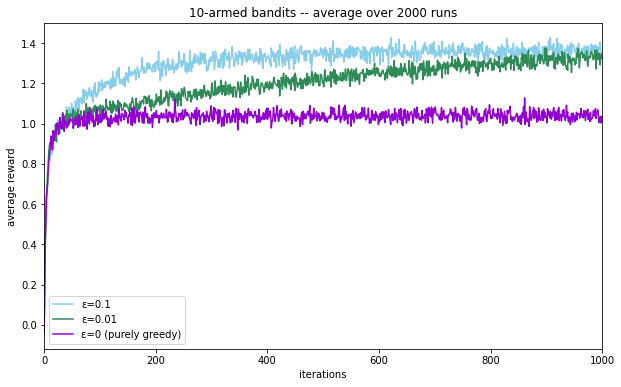

In [7]:
avg_reward_01 = np.mean(runs_rewards_01, axis=0)
avg_reward_001 = np.mean(runs_rewards_001, axis=0)
avg_reward_greedy = np.mean(runs_rewards_greedy, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(avg_reward_01, label="ε=0.1", color="skyblue")
plt.plot(avg_reward_001, label="ε=0.01", color="seagreen")
plt.plot(avg_reward_greedy, label="ε=0 (purely greedy)", color="darkviolet")
plt.xlabel("iterations")
plt.ylabel("average reward")
plt.legend()
plt.title("10-armed bandits -- average over 2000 runs")
plt.xlim(0, 1000)
plt.show()

La fréquence de choisir l'action optimale (la machine avec la plus grande moyenne) sur les 2000 runs pour les différentes valeurs de ε

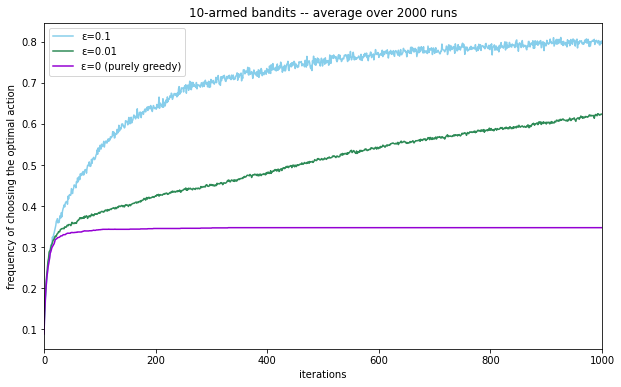

In [8]:
freq_opt_action_01 = np.mean(is_optimal_01, axis=0)
freq_opt_action_001 = np.mean(is_optimal_001, axis=0)
freq_opt_action_greedy = np.mean(is_optimal_greedy, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(freq_opt_action_01, label="ε=0.1", color="skyblue")
plt.plot(freq_opt_action_001, label="ε=0.01", color="seagreen")
plt.plot(freq_opt_action_greedy, label="ε=0 (purely greedy)", color="darkviolet")
plt.xlabel("iterations")
plt.ylabel("frequency of choosing the optimal action")
plt.legend()
plt.title("10-armed bandits -- average over 2000 runs")
plt.xlim(0, 1000)
plt.show()

## Deuxième approche : méthode de l'initialisation optimiste

In [9]:
def optimistic_initialisation_run(k, means, Q1=0, epsilon=0.01, alpha=0.1, niter=1000):
    # Effectuer niter itérations avec la méthode de l'initialisation optimiste
    Qt = np.full((k), Q1, dtype=float)
    Nt = np.zeros((k), dtype=float)
    best_known_action = np.random.randint(0, k)
    optimal_action = max(enumerate(means), key=lambda x: x[1])[0]
    rewards = np.zeros((niter))
    is_optimal = np.zeros((niter))
    for i in range(niter):
        if np.random.uniform() < epsilon:
            action = np.random.randint(0, k)
        else:
            action = best_known_action
        if action == optimal_action:
            is_optimal[i] = 1
        reward = play_machine(action, means)
        Nt[action] += 1
        Qt[action] += alpha * (reward - Qt[action])
        best_known_action = np.argmax(Qt)
        rewards[i] = reward
    return rewards, is_optimal

On lance 2000 runs de 1000 itérations (en échantillonnant de nouvelles moyennes pour chaque run) avec une fois une intialisation à 5 et en étant purement glouton et une autre fois avec une initialisation à 0 et un ε à 0.1 (meilleure valeur obtenue précédemment)

In [10]:
is_optimal_optimistic = np.zeros((2000, 1000))
is_optimal_realistic = np.zeros((2000, 1000))
for i in range(2000):
    means = generate_means(k)
    _, is_optimal_optimistic[i,:] = optimistic_initialisation_run(k, means, Q1=5, epsilon=0)
    _, is_optimal_realistic[i,:] = optimistic_initialisation_run(k, means, Q1=0, epsilon=0.1)

La fréquence de choisir l'action optimale (la machine avec la plus grande moyenne) sur les 2000 runs pour les différentes initialisations calculées ci-dessus

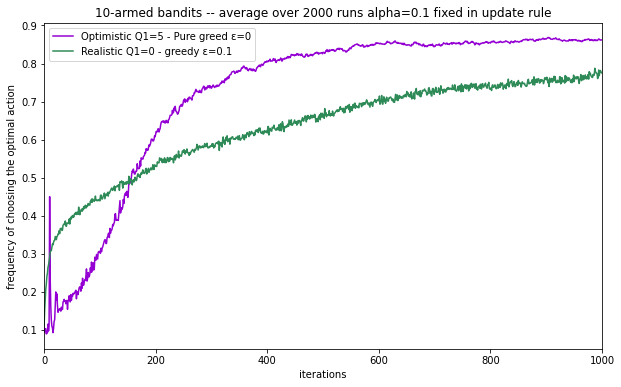

In [11]:
freq_opt_action_optimistic = np.mean(is_optimal_optimistic, axis=0)
freq_opt_action_realistic = np.mean(is_optimal_realistic, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(freq_opt_action_optimistic, label="Optimistic Q1=5 - Pure greed ε=0", color="darkviolet")
plt.plot(freq_opt_action_realistic, label="Realistic Q1=0 - greedy ε=0.1", color="seagreen")
plt.xlabel("iterations")
plt.ylabel("frequency of choosing the optimal action")
plt.legend()
plt.title("10-armed bandits -- average over 2000 runs alpha=0.1 fixed in update rule")
plt.xlim(0, 1000)
plt.show()

## Troisième approche : la méthode des intervalles de confiance

In [12]:
def ucb_run(k, means, c=0, Q1=0, alpha=None, niter=1000):
    # Effectuer niter itérations avec la méthode des intervalles de confiance
    Qt = np.full((k), Q1, dtype=float)
    Nt = np.zeros((k), dtype=float)
    best_known_action = np.random.randint(0, k)
    optimal_action = max(enumerate(means), key=lambda x: x[1])[0]
    rewards = np.zeros((niter))
    is_optimal = np.zeros((niter))
    for i in range(niter):
        action = best_known_action
        if action == optimal_action:
            is_optimal[i] = 1
        reward = play_machine(action, means)
        Nt[action] += 1
        if alpha:
            Qt[action] += (reward - Qt[action]) * alpha
        else:
            Qt[action] += (reward - Qt[action]) / Nt[action]
        UCBt = Qt + c * np.sqrt(np.divide(np.log(i + 1), Nt, out=np.full_like(Nt, np.inf), where=Nt!=0))
        best_known_action = np.argmax(UCBt)
        rewards[i] = reward
    return rewards, is_optimal

On lance 2000 runs de 1000 itérations (en échantillonnant de nouvelles moyennes pour chaque run) avec la méthode des intervalles de confiance et on la compare à celle de l'initialisation à 0 avec ε à 0.1 (meilleure valeur obtenue par la méthode ε-glouton)

In [13]:
is_optimal_ucb2 = np.zeros((2000, 1000))
is_optimal_realistic = np.zeros((2000, 1000))
for i in range(2000):
    means = generate_means(k)
    _, is_optimal_ucb2[i,:] = ucb_run(k, means, c=2)
    _, is_optimal_realistic[i,:] = optimistic_initialisation_run(k, means, Q1=0, epsilon=0.1)

La fréquence de choisir l'action optimale (la machine avec la plus grande moyenne) sur les 2000 runs pour la méthode des intevalles de confiance et la méthode ε-glonton avec ε=0.1

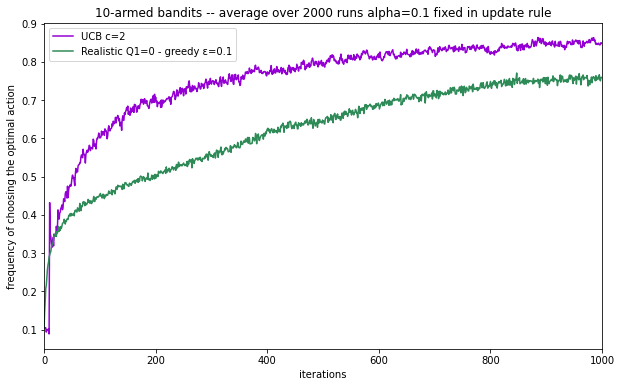

In [14]:
freq_opt_action_ucb2 = np.mean(is_optimal_ucb2, axis=0)
freq_opt_action_realistic = np.mean(is_optimal_realistic, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(freq_opt_action_ucb2, label="UCB c=2", color="darkviolet")
plt.plot(freq_opt_action_realistic, label="Realistic Q1=0 - greedy ε=0.1", color="seagreen")
plt.xlabel("iterations")
plt.ylabel("frequency of choosing the optimal action")
plt.legend()
plt.title("10-armed bandits -- average over 2000 runs alpha=0.1 fixed in update rule")
plt.xlim(0, 1000)
plt.show()

## Quatrième approche : la méthode de montée de gradient stochastique

On crée une fonction d'utilité pour la fonction "Softmax"

In [15]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

On crée une fonction qui lance un run avec la méthode de montée de gradient

In [16]:
def bandit_gradient_run(k, means, alpha=0.1, niter=1000):
    # Effectuer niter itérations avec la méthode de montée de gradient stochastique
    Rtbar = np.zeros((k), dtype=float)
    Nt = np.zeros((k), dtype=float)
    Ht = np.zeros((k), dtype=float)
    best_known_action = np.random.randint(0, k)
    optimal_action = max(enumerate(means), key=lambda x: x[1])[0]
    rewards = np.zeros((niter))
    is_optimal = np.zeros((niter))
    for i in range(niter):
        action = best_known_action
        if action == optimal_action:
            is_optimal[i] = 1
        reward = play_machine(action, means)
        Nt[action] += 1
        Rtbar[action] += (reward - Rtbar[action]) / Nt[action]
        πt = softmax(Ht)
        mask = np.zeros_like(πt)
        mask[action] = 1
        Ht += alpha * (reward - Rtbar) * (mask - πt)
        best_known_action = np.random.choice(k, p=πt)
        rewards[i] = reward
    return rewards, is_optimal

On lance 2000 runs de 1000 itérations (en échantillonnant de nouvelles moyennes pour chaque run) avec la méthode de montée de gradient stochastique et on la compare à celle de l'initialisation à 0 avec ε à 0.1 (meilleure valeur obtenue par la méthode ε-glouton)

In [17]:
is_optimal_bandit_gradient = np.zeros((2000, 1000))
is_optimal_realistic = np.zeros((2000, 1000))
for i in range(2000):
    means = generate_means(k)
    _, is_optimal_bandit_gradient[i,:] = bandit_gradient_run(k, means)
    _, is_optimal_realistic[i,:] = optimistic_initialisation_run(k, means, Q1=0, epsilon=0.1)

La fréquence de choisir l'action optimale (la machine avec la plus grande moyenne) sur les 2000 runs pour la méthode de montée de gradient stochastique et la méthode ε-glonton avec ε=0.1

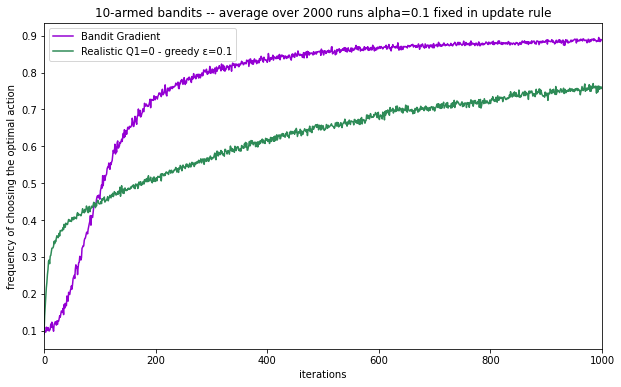

In [18]:
freq_opt_action_bandit_gradient = np.mean(is_optimal_bandit_gradient, axis=0)
freq_opt_action_realistic = np.mean(is_optimal_realistic, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(freq_opt_action_bandit_gradient, label="Bandit Gradient", color="darkviolet")
plt.plot(freq_opt_action_realistic, label="Realistic Q1=0 - greedy ε=0.1", color="seagreen")
plt.xlabel("iterations")
plt.ylabel("frequency of choosing the optimal action")
plt.legend()
plt.title("10-armed bandits -- average over 2000 runs alpha=0.1 fixed in update rule")
plt.xlim(0, 1000)
plt.show()